In [ ]:
from utils_deepcog import *
import multiprocessing
from multiprocessing import Pool
from datetime import datetime

os.environ['CUDA_VISIBLE_DEVICES'] = "0"  # Set the GPU card to use
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Or '3' for FATAL logs only
np.set_printoptions(suppress=True)
physical_devices = tf.config.list_physical_devices('GPU')
for gpu_instance in physical_devices:
    tf.config.experimental.set_memory_growth(gpu_instance, True)


In [ ]:
city = 'Milan'
nr = 21
lookback = 3
epochs = 20 # 20
batchsize = 32
# Load cells based on the city
cells = get_rows_Milan(5060, nr)

output_directory = '../../../../oracle-data/serly/Scalable_dnn/PerBS/'
model_dir = f'../../../../oracle-data/serly/Scalable_dnn/Trained_models/Per_BS/LSTM/{city}/'
os.makedirs(model_dir, exist_ok=True)

In [3]:
def preprocess_data(cell, output_directory, city, lookback, data_type="train"):
    """
    Preprocesses the time series data for a cell, applying normalization and 
    constructing the input X with the given lookback window.

    Args:
        cell (int): Identifier for the cell.
        output_directory (str): Directory where the data is stored.
        city (str): City name to structure the path.
        lookback (int): Number of past time steps to include as input features.
        nr (int): Not used but can be removed or modified as needed.
        data_type (str): Either "train" or "test" to specify data type.

    Returns:
        X (np.ndarray): Preprocessed inputs with shape (n_samples, lookback, 1).
        y (np.ndarray): Corresponding targets with shape (n_samples, 1).
        scaler (MinMaxScaler): Fitted scaler object for inverse normalization.
    """
    X, y = [], []

    # Load the time series data for the cell (train or test depending on data_type)
    file_path = os.path.join(output_directory, f'{city}/{data_type}_{cell}.npy')
    ts_data = np.load(file_path)

    # Normalize the time series data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    ts_data = ts_data.reshape(-1, 1)  # Reshape to 2D array for the scaler
    ts_data_normalized = scaler.fit_transform(ts_data).flatten()

    # Create the lookback data
    for t in range(len(ts_data_normalized) - lookback):
        X.append(ts_data_normalized[t:t + lookback])
        y.append(ts_data_normalized[t + lookback])

    X = np.array(X).reshape(-1, lookback, 1)  # Reshape to (n_samples, lookback, 1)
    y = np.array(y).reshape(-1, 1)  # Reshape to (n_samples, 1)

    return X, y, scaler


In [ ]:
def model_lstm_custom(lookback, num_input, num_output):
    """Creates a model for time series forecasting with num_input cells as input and num_output cells as output."""
    model = models.Sequential()
    model.add(layers.LSTM(5, activation='tanh', input_shape=(lookback, num_input)))
    model.add(layers.Dense(num_output))  # Output one value (next time step for a specific cell)

    loss_function = 'mae' 
    optimizer = Adam(learning_rate=0.0005, beta_1=0.85, beta_2=0.98)
    model.compile(optimizer=optimizer, loss=loss_function)
    return model

Train

In [ ]:
for cell in cells:
    test_X, test_Y, scaler = preprocess_data(cell, output_directory, city, lookback, data_type="train")
    print(test_X.shape, test_Y.shape)
    # train lstm model
    model = model_lstm(lookback, 1, 1)
    model.fit(test_X, test_Y, epochs=epochs, batch_size=batchsize, verbose=0)
    # save model
    model.save(f'{model_dir}/model_{cell}.h5')

Evaluate

In [4]:
MAE_errors = []
for cell in cells:
    test_X, test_Y, scaler = preprocess_data(cell, output_directory, city, lookback, data_type="test")
    length = 1780 if city == 'Milan' else 400
    test_X = test_X[:length]
    test_Y = test_Y[:length]
    # load model
    model = tf.keras.models.load_model(f'{model_dir}/model_{cell}.h5')
    # evaluate model
    predicted = model.predict(test_X)
    test_Y = scaler.inverse_transform(test_Y)
    predicted = scaler.inverse_transform(predicted)
    error = mean_absolute_error(test_Y, predicted)
    print(f'Cell {cell} MAE: {error}')
    # print(f'Cell {cell} MAE: {error}')
    MAE_errors = np.append(MAE_errors, error)

print(f'MAE: {(MAE_errors)}')

Cell 4050 MAE: 7.089507126199266
Cell 4051 MAE: 5.540070857289512
Cell 4052 MAE: 5.201059107409469
Cell 4053 MAE: 10.35356588813001
Cell 4054 MAE: 9.50394227188741
Cell 4055 MAE: 18.640677476319325
Cell 4056 MAE: 18.52130199503021
Cell 4057 MAE: 12.498449511938935
Cell 4058 MAE: 10.175675189798374
Cell 4059 MAE: 11.331993963960654
Cell 4060 MAE: 13.596303743953067
Cell 4061 MAE: 11.740140712349861
Cell 4062 MAE: 12.446616171395611
Cell 4063 MAE: 10.301068140223926
Cell 4064 MAE: 12.786014205024827
Cell 4065 MAE: 4.653814484997919
Cell 4066 MAE: 2.0786688258191326
Cell 4067 MAE: 4.816198003800887
Cell 4068 MAE: 21.184259235991053
Cell 4069 MAE: 17.593184293492353
Cell 4070 MAE: 4.39722000240532
Cell 4150 MAE: 14.3312685268472
Cell 4151 MAE: 7.674918911111259
Cell 4152 MAE: 10.731580007727063
Cell 4153 MAE: 8.955532828177997
Cell 4154 MAE: 10.66564192740186
Cell 4155 MAE: 16.574579327207143
Cell 4156 MAE: 14.826171063490984
Cell 4157 MAE: 12.640532823694306
Cell 4158 MAE: 10.358356792516

In [5]:
MAE_errors_sum = np.sum(MAE_errors)
print(f'Total MAE: {MAE_errors_sum}')

MAE_errors_sum = "{:.2e}".format(MAE_errors_sum)
print(f'Total MAE: {MAE_errors_sum}')

Total MAE: 7840.702480462418
Total MAE: 7.84e+03


(1780, 3, 1) (1780, 1)


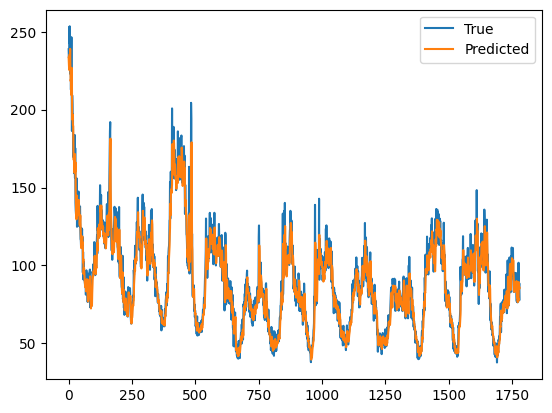

Cell 4050 MAE: 7.089507126199266


In [5]:
# visualize for one cell
cell = cells[0]
length = 1780 if city == 'Milan' else 400
test_X, test_Y, scaler = preprocess_data(cell, output_directory, city, lookback, data_type="test")
test_X = test_X[:length]
test_Y = test_Y[:length]
print(test_X.shape, test_Y.shape)
model = tf.keras.models.load_model(f'{model_dir}/model_{cell}.h5')
predicted = model.predict(test_X)
predicted = scaler.inverse_transform(predicted)
test_Y = scaler.inverse_transform(test_Y)
plt.plot(test_Y, label='True')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()
error = mean_absolute_error(test_Y, predicted)
print(f'Cell {cell} MAE: {error}')
